In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
from postgres.config import SessionLocal
from postgres.models import AdvancedPlayerStats, ClusteredPlayers





In [3]:
session = SessionLocal()

players = session.query(AdvancedPlayerStats).all()
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {column.name: getattr(player, column.name) for column in player.__table__.columns}
    data.append(player_dict)

df = pd.DataFrame(data)

df.set_index('PLAYER', inplace=True)


df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['id', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
# df = df.astype(float)
df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
nicolas batum,36,17.7,106.8,101.9,4.9,10.6,2.90,29.0,3.6,11.3,...,8.9,101.9,11.3,19.3,22.5,6.5,4.7,5.2,16.0,0.104
alperen sengun,22,31.4,115.0,106.3,8.7,25.2,2.02,19.8,9.8,21.7,...,53.1,106.3,21.7,24.2,27.5,9.5,8.4,8.4,30.6,0.141
amir coffey,27,25.3,109.1,106.5,2.6,6.7,1.64,11.4,2.1,7.6,...,16.7,106.5,7.6,12.4,3.1,10.6,6.2,8.6,25.5,0.112
deni avdija,24,28.2,110.3,117.3,-7.0,17.1,1.34,18.3,4.4,17.9,...,43.1,117.3,17.9,23.7,19.8,11.6,8.7,10.5,27.6,0.037
donte divincenzo,27,26.4,110.5,109.2,1.3,20.1,2.03,23.6,2.1,10.8,...,25.0,109.2,10.8,27.3,5.9,11.1,8.3,8.1,25.7,0.098


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,nicolas batum,36,17.7,106.8,101.9,4.9,10.6,2.90,29.0,3.6,...,8.9,101.9,11.3,19.3,22.5,6.5,4.7,5.2,16.0,0.104
1,alperen sengun,22,31.4,115.0,106.3,8.7,25.2,2.02,19.8,9.8,...,53.1,106.3,21.7,24.2,27.5,9.5,8.4,8.4,30.6,0.141
2,amir coffey,27,25.3,109.1,106.5,2.6,6.7,1.64,11.4,2.1,...,16.7,106.5,7.6,12.4,3.1,10.6,6.2,8.6,25.5,0.112
3,deni avdija,24,28.2,110.3,117.3,-7.0,17.1,1.34,18.3,4.4,...,43.1,117.3,17.9,23.7,19.8,11.6,8.7,10.5,27.6,0.037
4,donte divincenzo,27,26.4,110.5,109.2,1.3,20.1,2.03,23.6,2.1,...,25.0,109.2,10.8,27.3,5.9,11.1,8.3,8.1,25.7,0.098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,jordan clarkson,32,25.6,105.2,117.6,-12.4,26.2,1.53,18.1,2.4,...,60.5,117.6,10.1,20.7,14.9,13.5,10.0,10.2,27.8,0.031
307,herbert jones,26,32.4,111.8,112.5,-0.7,13.4,1.86,22.3,3.3,...,21.3,112.5,8.5,27.0,11.1,12.7,9.9,10.5,34.5,0.088
308,day'ron sharpe,23,17.4,108.2,111.9,-3.7,13.5,1.33,15.2,14.9,...,43.8,111.9,21.3,26.9,31.0,7.9,5.1,5.4,15.4,0.050
309,micah potter,26,17.3,106.6,108.9,-2.4,6.3,1.30,17.6,5.9,...,10.5,108.9,14.7,8.3,21.4,4.9,5.3,6.6,16.1,0.063


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4294079707933065
Variance with 3 components: 0.533632931033884
Variance with 4 components: 0.6338321271367662
Variance with 5 components: 0.6874602715594396
Variance with 6 components: 0.7319376046244012
Variance with 7 components: 0.7673502050052016
Variance with 8 components: 0.798494330491591
Variance with 9 components: 0.8239130429886874
Variance with 10 components: 0.8477388161771825
Variance with 11 components: 0.8681033217310158
Variance with 12 components: 0.8878782353809699
Variance with 13 components: 0.903854254078723
Variance with 14 components: 0.9185797693905053
Variance with 15 components: 0.9328481599635604
Variance with 16 components: 0.944659526468541
Variance with 17 components: 0.9547199035935032
Variance with 18 components: 0.9637276790292464
Variance with 19 components: 0.9713336927894687
Variance with 20 components: 0.9780560745838849
Variance with 21 components: 0.9834311472531262
Variance with 22 components: 0.9875307402312198
Vari

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

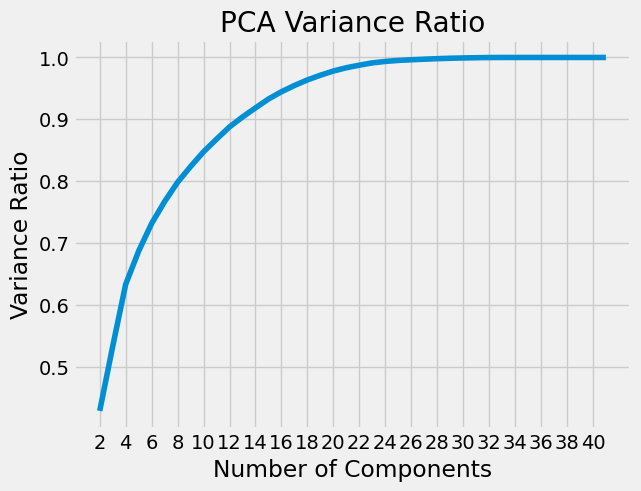

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.04224960e-01 1.00199196e-01 5.36281444e-02 4.44773331e-02
 3.54126004e-02 3.11441255e-02 2.54187125e-02 2.38257732e-02
 2.03645056e-02 1.97749136e-02 1.59760187e-02 1.47255153e-02
 1.42683906e-02 1.18113665e-02 1.00603771e-02 9.00777544e-03
 7.60601376e-03 6.72238179e-03 5.37507267e-03 4.09959298e-03
 3.72660737e-03 2.32715563e-03 1.63046216e-03 1.07207198e-03
 8.98200992e-04 8.45100541e-04 6.97756806e-04 4.71564157e-04
 3.82713681e-04 2.84150901e-04 1.13249234e-04 1.95868152e-05
 5.32063273e-07 9.52049017e-08 5.83624160e-09 4.72269379e-09
 1.66652536e-09 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

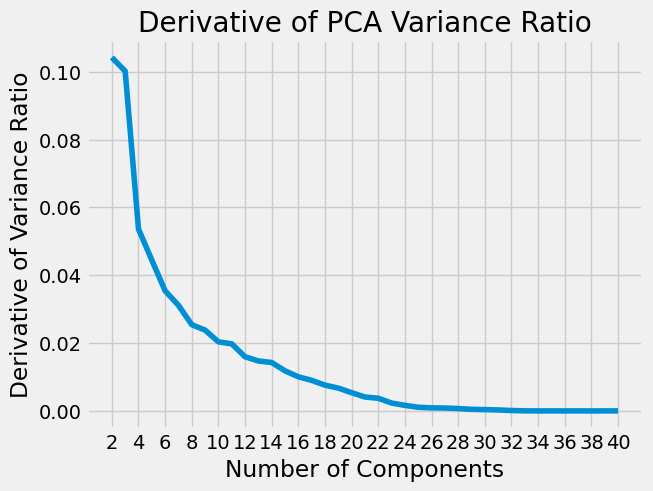

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21791971 0.21148826 0.10422496 0.1001992  0.05362814 0.04447733
 0.0354126  0.03114413 0.02541871 0.02382577 0.02036451 0.01977491
 0.01597602 0.01472552 0.01426839 0.01181137]
0.944659526468541


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.14923973939091129
Silhouette Score with 3 clusters: 0.1896995023538181
Silhouette Score with 4 clusters: 0.1376234946999474
Silhouette Score with 5 clusters: 0.12407255020013026
Silhouette Score with 6 clusters: 0.1118536455475097
Silhouette Score with 7 clusters: 0.10909389826647879
Silhouette Score with 8 clusters: 0.10263102728623888
Silhouette Score with 9 clusters: 0.10979818641810055
Silhouette Score with 10 clusters: 0.10307914877370153
Silhouette Score with 11 clusters: 0.10320030156754771
Silhouette Score with 12 clusters: 0.10228278562018435
Silhouette Score with 13 clusters: 0.10409262530514361
Silhouette Score with 14 clusters: 0.10026966697501886
Silhouette Score with 15 clusters: 0.08534503285697093
Silhouette Score with 16 clusters: 0.08706021870499217
Silhouette Score with 17 clusters: 0.09014018749246486


Silhouette Score with 18 clusters: 0.09110594536605829
Silhouette Score with 19 clusters: 0.08810612862929608
Silhouette Score with 20 clusters: 0.09003253472298388
Silhouette Score with 21 clusters: 0.09006971886293609
Silhouette Score with 22 clusters: 0.0844391501304143
Silhouette Score with 23 clusters: 0.07997264530510424
Silhouette Score with 24 clusters: 0.07755961444493113
Silhouette Score with 25 clusters: 0.07670406198925686
Silhouette Score with 26 clusters: 0.07990648043218052
Silhouette Score with 27 clusters: 0.07606175944228058
Silhouette Score with 28 clusters: 0.07658812867425838
Silhouette Score with 29 clusters: 0.07781144121823372
Silhouette Score with 30 clusters: 0.07693320269950818
Silhouette Score with 31 clusters: 0.07693273480996042


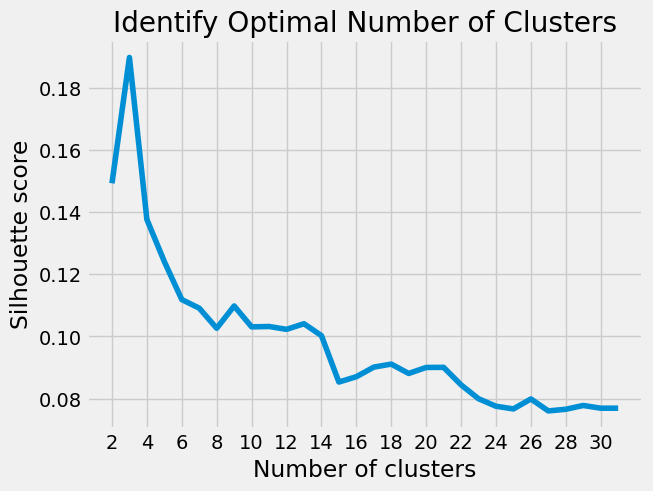

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = 0.04755718483364557
for n_cluseter = 4, improvement = -0.06426752520224888
for n_cluseter = 5, improvement = -0.015713489892795973
for n_cluseter = 6, improvement = -0.013949676603253414
for n_cluseter = 7, improvement = -0.003107311387583467
for n_cluseter = 8, improvement = -0.007254267276500359
for n_cluseter = 9, improvement = 0.007986858638746264
for n_cluseter = 10, improvement = -0.007547768991127635
for n_cluseter = 11, improvement = 0.00013507634891141151
for n_cluseter = 12, improvement = -0.0010231001961387154
for n_cluseter = 13, improvement = 0.002016046541125527
for n_cluseter = 14, improvement = -0.00426713568623871
for n_cluseter = 15, improvement = -0.016587897028957466
for n_cluseter = 16, improvement = 0.0018752271726886205
for n_cluseter = 17, improvement = 0.0033736823069576705
for n_cluseter = 18, improvement = 0.0010614359050894473
for n_cluseter = 19, improvement = -0.003300513103224434
for n_cluseter = 20, improvement = 0.00211

C:\conda_tmp\ipykernel_27416\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


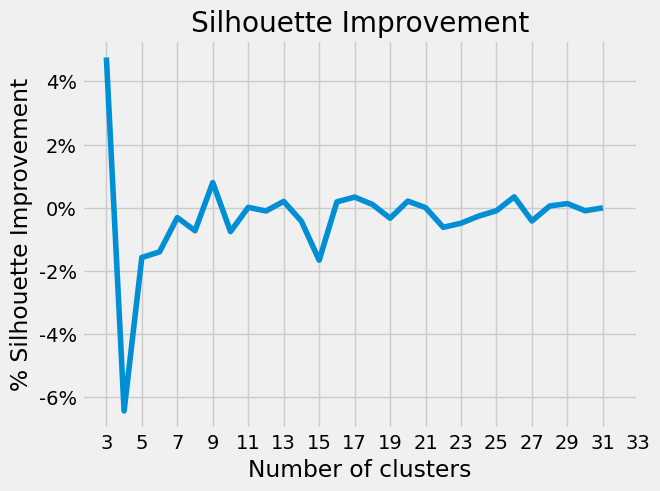

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,nicolas batum,0
1,alperen sengun,9
2,amir coffey,7
3,deni avdija,14
4,donte divincenzo,3


In [17]:
df_cluster.columns = df_cluster.columns.str.upper()
for _, row in df_cluster.iterrows():
    existing_player = session.query(ClusteredPlayers).filter_by(PLAYER=row['PLAYER']).first()
    if existing_player:
        # Update the cluster value if the player exists
        existing_player.CLUSTER = row['CLUSTER']
    else:
        # Convert the row to a dictionary and pass it to the model
        clustered_player = ClusteredPlayers(
            PLAYER=row['PLAYER'],
            CLUSTER=row['CLUSTER']
        )
        session.add(clustered_player)
session.commit()

session.close()